<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir img

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002




In [4]:
# Training
dataset = torchvision.datasets.MNIST("mnist_data", train=True, download=True,
                                     transform=torchvision.transforms.Compose(
                                         [
                                             torchvision.transforms.Resize(32),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize([0.5], [0.5]),
                                         ]
                                                                             )
                                     )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf , 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf ),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf , nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LayerNorm([ndf, 16, 16]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LayerNorm([ndf*2, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([ndf*4, 4, 4]),
            # state size. (ndf*2) x 4 x 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            #nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)


In [10]:
def compute_gradient_penalty(D, real_images, fake_images,device):
  b,c,h,w = real_images.shape
  alpha = torch.rand(b,1,1,1).repeat((1,c,h,w)).to(device)
  interplated = (alpha * real_images.data + (1-alpha)*fake_images.data).requires_grad_(True)
  out = D(interplated)
  grad = torch.autograd.grad(
      outputs=out,
      inputs=interplated,
      grad_outputs = torch.ones(out.size()).to(device),
      retain_graph = True,
      create_graph =True,
      only_inputs=True
  )[0]
  grad_l2norm = grad.norm(2, dim=[1,2,3])
  gradient_penalty = torch.mean((grad_l2norm - 1) ** 2)
  return gradient_penalty


In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
loss_fn = lambda x:x.mean()
def train_one_epoch(dataloader,generator,discriminator,epoch,Goptim,Doptim,loss_fn,critic,lambda_,log):
  generator.train()
  discriminator.train()
  for batch,(x,_) in enumerate(dataloader):
    x = x.to(device)
    z = torch.randn(batch_size,nz,1,1,device=device)
    pre_img = generator(z)
    real_loss = loss_fn(discriminator(x))
    fake_loss = loss_fn(discriminator(pre_img.detach()))
    grad = compute_gradient_penalty(discriminator,x,pre_img,device)

    D_loss =  fake_loss - real_loss + lambda_ * grad
    
    Doptim.zero_grad()
    D_loss.backward()
    Doptim.step()
    log['D_loss'].append(D_loss.item())

    
    if batch % critic==0:
      z = torch.randn(batch_size,nz,1,1,device=device)
      G_loss = - loss_fn(discriminator(generator(z)))
      Goptim.zero_grad()
      G_loss.backward()
      Goptim.step()
      log['G_loss'].append(G_loss.item())
    if batch % 40 ==0:
      print(f"step:{len(dataloader)*epoch+batch}, g_loss:{G_loss.item()}, d_loss:{D_loss.item()},real_loss:{real_loss.item()},fake_loss:{fake_loss.item()}")
    if batch % 5000 == 0:
      image = pre_img[:16].data
      torchvision.utils.save_image(image, f"./img/image_{len(dataloader)*epoch+batch}.png", nrow=4)


if __name__ == '__main__':
  G = Generator()
  D = Discriminator()
  # Optimizers
  optimizer_G = torch.optim.Adam(G.parameters(),betas=(0,0.9),lr=lr)#改进4、不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行
  optimizer_D = torch.optim.Adam(D.parameters(),betas=(0,0.9),lr=lr)
  log = {}
  log['D_loss'] =[]
  log['G_loss'] =[]
  lambda_= 10
  critic = 5
  G = G.to(device)
  D = D.to(device)

  for epoch in range(num_epochs):
    train_one_epoch(dataloader,G,D,epoch,optimizer_G,optimizer_D,loss_fn,critic,lambda_,log)   
    if epoch % 5 ==0:
      checkpoint = {
          "G_model":G.state_dict(),
          "D_model":D.state_dict(),
          "G_optim":optimizer_G.state_dict(),
          "D_optim":optimizer_D.state_dict(),
          "epoch":epoch,
      }
      torch.save(checkpoint,f'epoch_{epoch}_ckpt.ckpt')




      

step:0, g_loss:0.6122647523880005, d_loss:20.43430519104004,real_loss:-0.7796869874000549,fake_loss:-0.044611766934394836
step:40, g_loss:2.113246440887451, d_loss:-8.002437591552734,real_loss:8.849624633789062,fake_loss:-4.968121528625488
step:80, g_loss:10.02241325378418, d_loss:-8.332843780517578,real_loss:4.5121989250183105,fake_loss:-4.784987449645996
step:120, g_loss:8.868094444274902, d_loss:-8.717887878417969,real_loss:1.4509680271148682,fake_loss:-10.425654411315918
step:160, g_loss:10.364595413208008, d_loss:-7.444421768188477,real_loss:1.8753464221954346,fake_loss:-8.556194305419922
step:200, g_loss:11.436012268066406, d_loss:-5.853896141052246,real_loss:-2.5603411197662354,fake_loss:-10.13680648803711
step:240, g_loss:12.247563362121582, d_loss:-5.595541954040527,real_loss:-1.125160574913025,fake_loss:-8.99294376373291
step:280, g_loss:12.849571228027344, d_loss:-5.786623954772949,real_loss:-3.510953664779663,fake_loss:-11.031031608581543
step:320, g_loss:10.302324295043945

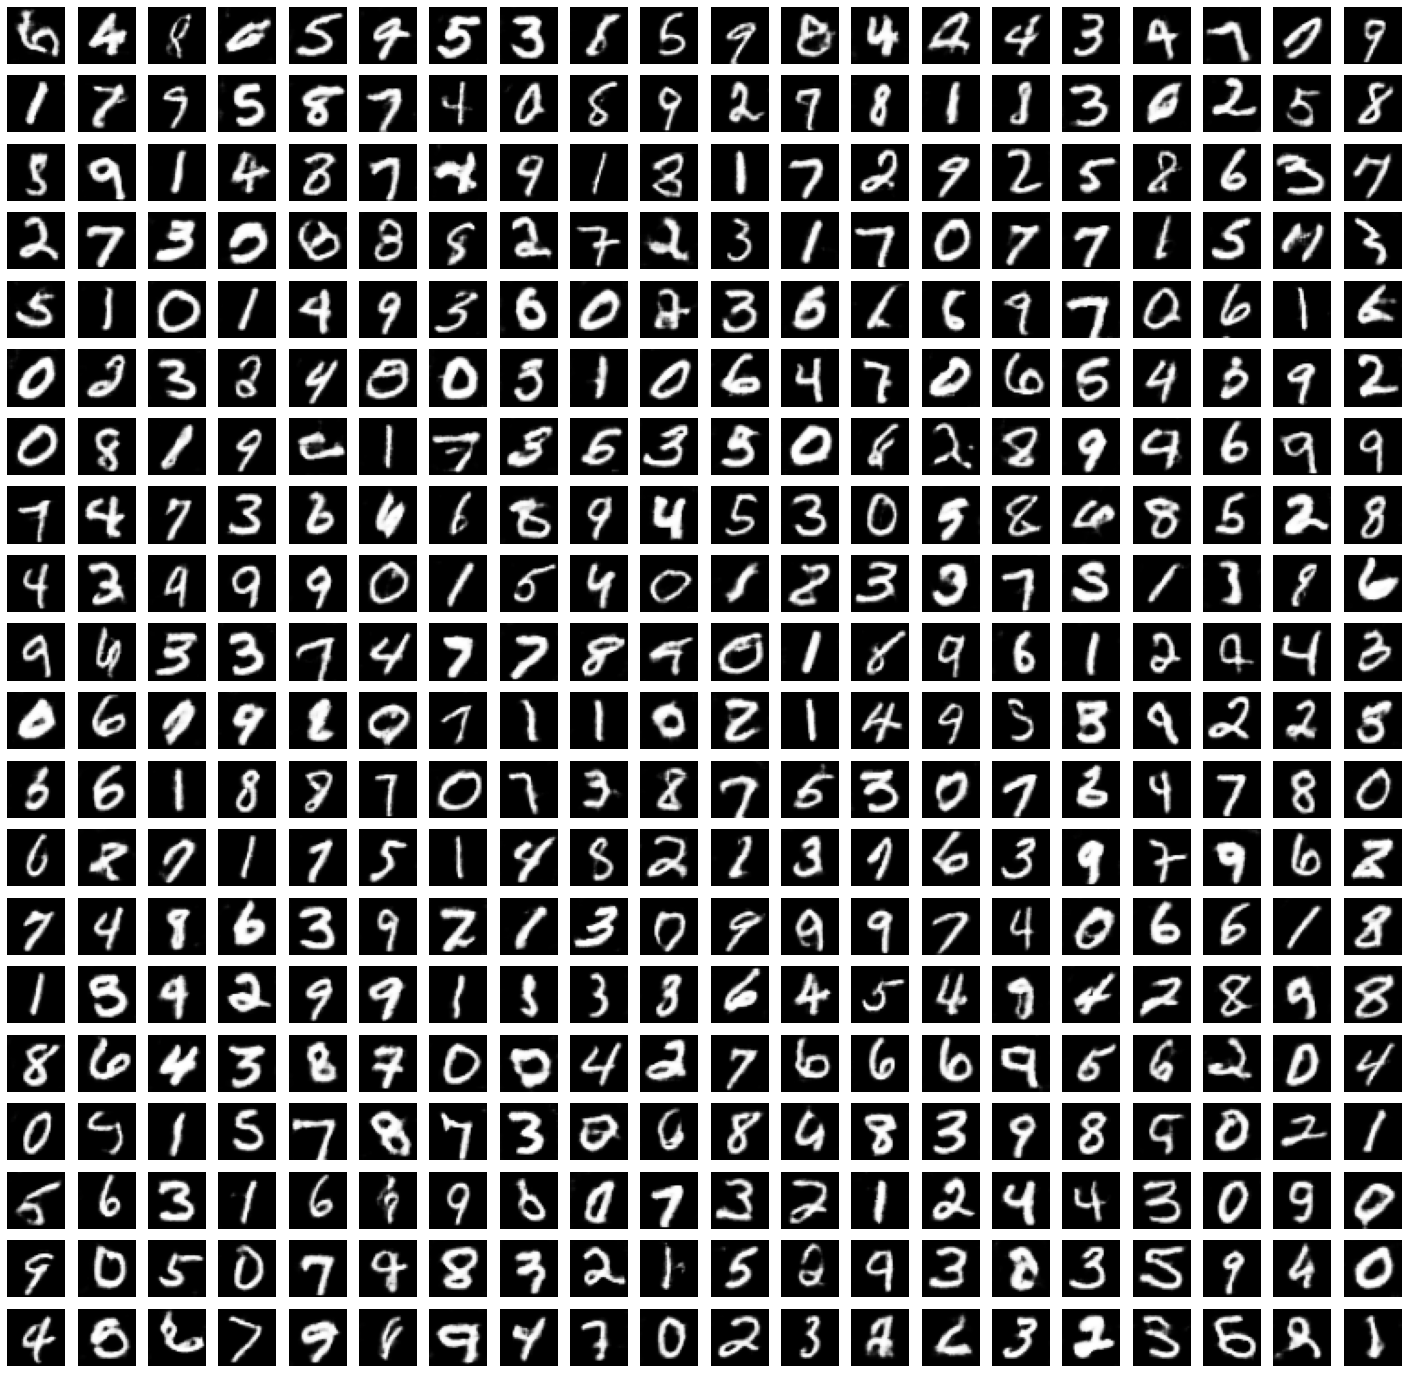

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
n = 20
digit_size = 32

noise = torch.randn(n*n,nz,1,1,device=device)

G.eval()
plt.figure(figsize=(25,25))
with torch.no_grad():
    pre_img = G(noise).detach().cpu()
    for index in range(pre_img.size(0)):
      digit = pre_img[index].view((digit_size, digit_size))
      plt.subplot(n,n,index+1)
      plt.imshow(digit,cmap="Greys_r")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off');

plt.show()